In [14]:
# CS 8803 Efficient Machine Learning
# Saad Amin
# GT ID: 903997706
# Date: 9/22/2025

# Lab 01: Pruning

# going to import everything here
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
import copy

import tqdm

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

if torch.cuda.is_available():
    device = "cuda"
    print(f"Using GPU {torch.cuda.get_device_name(0)}") 
else:
    raise RuntimeError("Unable to use CUDA!")


Using GPU NVIDIA L40S


# [40%] Task 01: Basic Pruning Techniques and Observations

In this section, we will explore neural network pruning using PyTorch to understand how removing parameters affects model performance and efficiency. Pruning is a model compression technique that removes unnecessary weights or neurons from trained neural networks while attempting to maintain accuracy. We will use [PyTorch's pruning library](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html) to implement various pruning strategies.

## What is Pruning?

Neural network pruning systematically removes weights, neurons, or entire layers from a trained model to reduce computational complexity and memory requirements. The key insight is that many neural networks are over-parameterized, containing redundant connections that can be eliminated without significantly impacting performance.

This section is worth **40%** of the total lab grade.

---

## Task Overview

Complete the following tasks in order:

1. **Download and visualize a dataset** - Load and explore the dataset characteristics
2. **Train a model from scratch** - Implement and train a baseline neural network
3. **Evaluate the baseline model** - Measure accuracy, model size, and inference time
4. **Apply pruning techniques** - Implement magnitude-based pruning with different sparsity levels
5. **Analyze pruning sensitivity** - Visualize how different layers respond to pruning
6. **Compare performance trade-offs** - Document accuracy vs. compression relationships
7. **Reflection and analysis** - Explain your observations and lessons learned

**Deliverables:** Code implementation, visualization plots, performance analysis, and written explanations for each task.

### [5%] Part a: Download the dataset and view an image.
Using torch vision, download the CIFAR10 dataset into the Google Colab.
Create a train and test set. In torchvision you can do this by doing:

```
torchvision.datasets.DATASET(root='./data',train=[true/false],download=True)
```
You do not need to add transformations.

Then, write a function to show an image from each class. The final result should look something like this:

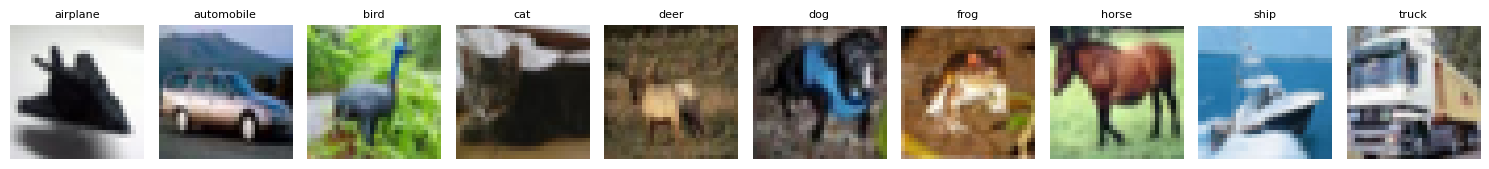


In [2]:
#####
# Write your code here to download the CIAR10 dataset.
#

# Data transforms
transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

# Dataset and DataLoader
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=384, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)

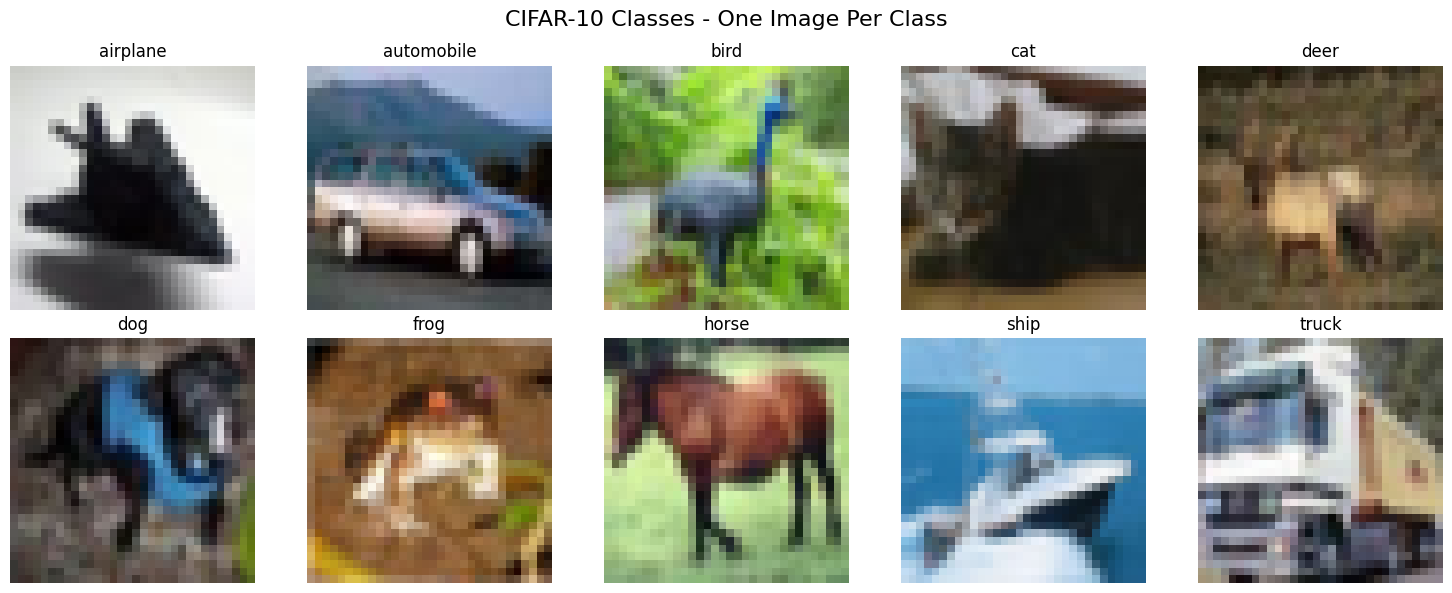

In [3]:
####
# Write your code here to visualize all 10 classes from CIFAR10.
#

def show_one_image_per_class(dataset):
    # CIFAR-10 class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Dictionary to store one image per class
    class_images = {}
    class_labels = {}
    
    # Find one image for each class
    for i, (image, label) in enumerate(dataset):
        if label not in class_images:
            class_images[label] = image
            class_labels[label] = label
        
        # Stop when we have one image for each class
        if len(class_images) == 10:
            break
    
    # Create subplot grid
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('CIFAR-10 Classes - One Image Per Class', fontsize=16)
    
    # Plot images
    for i in range(10):
        row = i // 5
        col = i % 5
        
        image = class_images[i]
        
        # Convert tensor to numpy array and transpose dimensions
        # CIFAR-10 images are in CHW format, matplotlib expects HWC
        if isinstance(image, torch.Tensor):
            img_array = image.permute(1, 2, 0).numpy()
        else:
            img_array = np.transpose(image, (1, 2, 0))
        
        # Normalize pixel values to [0, 1] if they're not already
        if img_array.max() > 1.0:
            img_array = img_array / 255.0
        
        # Handle negative values (in case of normalization transforms)
        img_array = np.clip(img_array, 0, 1)

        axes[row, col].imshow(img_array)
        axes[row, col].set_title(f'{class_names[i]}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
show_one_image_per_class(train_dataset)

### [10%] Part b: Train a Neural Network, Count Parameters, and Evaluate

#### [5%] Training a ResNet Model for CIFAR-10

Using the provided network definition below, create a ResNet architecture configured for the CIFAR-10 dataset. You will need to:

1. **Configure the model architecture**:
  - Set the number of input channels to match CIFAR-10 images (3 RGB channels)
  - Set the number of output classes to match CIFAR-10 labels (10 classes)

2. **Train the model**:
  - Use the provided training code
  - Train for exactly **10 epochs**
  - Monitor training progress and loss

3. **Evaluate model performance**:
  - Test the trained model on the CIFAR-10 test set
  - Record the final accuracy

**Expected Results**: You should achieve approximately **85% accuracy**. Minor variations (±2-3%) are normal and acceptable. The goal is to understand the pruning process, not to create a state-of-the-art classifier.

#### [5%] Parameter Analysis

After training, analyze your model's structure by counting the parameters in each module:

1. **Count total parameters** in the entire model
2. **Count parameters by layer type** (convolutional layers, batch normalization, fully connected layers)
3. **Create a summary table** showing parameter distribution across the network
4. **Identify the most parameter-heavy modules**

This analysis will help you understand which parts of the network are most affected by pruning in the next section.

---

In [4]:
# Model definition, DO NOT CHANGE
# You will be training this model.

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# Model definition, DO NOT CHANGE
# You will be training this model.

In [5]:
####
# Your model definition
#
# You need to finish this one.
model = ResNet9(in_channels=3, num_classes=10)
model.to(device)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [6]:
# Training code for model
# Complete the training loop where it says to modify.

def train(model, train_loader, num_epochs, lr=1e-3, weight_decay=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.65)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # IMPORTANT: You need to finish this.
        # Complete training loop here

        for i, (input, labels) in enumerate(train_loader):
            input, labels = input.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            logits = model(input)

            loss = criterion(logits, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()


        running_loss /= len(train_loader)

        scheduler.step()

        print(f"Epoch [{epoch+1:3d}] | Train Loss: {running_loss / len(train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")


In [7]:
####
# Train the model.
#
# You need to finish this one.
train(model, train_loader, num_epochs=10)

Epoch [  1] | Train Loss: 0.0093 | LR: 0.000650
Epoch [  2] | Train Loss: 0.0051 | LR: 0.000423
Epoch [  3] | Train Loss: 0.0034 | LR: 0.000275
Epoch [  4] | Train Loss: 0.0023 | LR: 0.000179
Epoch [  5] | Train Loss: 0.0015 | LR: 0.000116
Epoch [  6] | Train Loss: 0.0008 | LR: 0.000075
Epoch [  7] | Train Loss: 0.0004 | LR: 0.000049
Epoch [  8] | Train Loss: 0.0002 | LR: 0.000032
Epoch [  9] | Train Loss: 0.0002 | LR: 0.000021
Epoch [ 10] | Train Loss: 0.0001 | LR: 0.000013


In [8]:
####
# Evaluate the model.
#
# You need to finish this one.

@torch.inference_mode()
def evaluate_test(model,dataloader):
  # you write this
  # need to return test loss and accuracy
  # use cross-entropy loss
  # be sure to have torch.no_grad

  model.eval()


  correct = 0
  total = 0

  running_loss = 0.0

  for i, (input, labels) in enumerate(dataloader):
    input, labels = input.to(device, non_blocking=True), labels.to(device, non_blocking=True)

    logits = model(input)

    loss = F.cross_entropy(logits, labels)

    _, predicted = logits.max(1)
    correct += predicted.eq(labels).sum().item()

    total += logits.size(0)

    running_loss += loss.item()

  return running_loss / len(dataloader), 100 * correct / total




test_loss, test_acc = evaluate_test(model, test_loader)

# print the loss and accuracy neatly here
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")


Test Loss: 0.4406
Test Accuracy: 86.58%


In [ ]:
####
# Count total parameters.
#
# You need to finish this.

def count_params(model):
    # need to return the number of parameters of the model
    # use model.parameters() and numel()
    # should get about 6.5 million
    return sum(p.numel() for p in model.parameters())

total_params = count_params(model)  
# print params here in terms if millions of params with 3 decimal places
print(f"Total parameters: {total_params / 1e6:.3f} million")

Total parameters: 6.575 million


In [10]:
####
# Count module specific parameters
# print the list of modules by parameter count
# res2.0.0 and res2.1.0 should be highest
# use module.named_modules, numel(), and module.parameters
# should get something like:
# [('res2.0.0', 2359808),
#  ('res2.1.0', 2359808),
#  ('conv4.0', 1180160),
#  ('conv3.0', 295168),
#  ('res1.0.0', 147584),
#  ('res1.1.0', 147584),
#  ('conv2.0', 73856),
#  ('classifier.2', 5130),
#  ('conv1.0', 1792),
#  ('conv4.1', 1024),
#  ('res2.0.1', 1024),
#  ('res2.1.1', 1024),
#  ('conv3.1', 512),
#  ('conv2.1', 256),
#  ('res1.0.1', 256),
#  ('res1.1.1', 256),
#  ('conv1.1', 128)]
#
# you need to finish this

def count_parameters_by_module(model):
  # sorted list of (module_name,param_count) tuples
  # sorted in descending order by number of parameters
  module_param_counts = []

  for name, module in model.named_modules():
      if name and list(module.parameters(recurse=False)):
          param_count = sum(p.numel() for p in module.parameters(recurse=False))
          module_param_counts.append((name, param_count))
  
  # Sort by parameter count in descending order
  module_param_counts.sort(key=lambda x: x[1], reverse=True)
  
  return module_param_counts



module_counts = count_parameters_by_module(model)

# Print the list here
print("Module parameter counts:")
for name, count in module_counts:
    print(f"  {name}:\t{count:,}\tparameters")

Module parameter counts:
  res2.0.0:	2,359,808	parameters
  res2.1.0:	2,359,808	parameters
  conv4.0:	1,180,160	parameters
  conv3.0:	295,168	parameters
  res1.0.0:	147,584	parameters
  res1.1.0:	147,584	parameters
  conv2.0:	73,856	parameters
  classifier.2:	5,130	parameters
  conv1.0:	1,792	parameters
  conv4.1:	1,024	parameters
  res2.0.1:	1,024	parameters
  res2.1.1:	1,024	parameters
  conv3.1:	512	parameters
  conv2.1:	256	parameters
  res1.0.1:	256	parameters
  res1.1.1:	256	parameters
  conv1.1:	128	parameters


### [15%] Part c: Prune the Network and Analyze Sensitivities

# ResNet Pruning and Sensitivity Analysis

## [7.5%] Pruning and Sensitivity Analysis

You will apply structured pruning to your trained ResNet model and evaluate how pruning different components affects performance. Complete the analysis in two stages:

### Stage 1: Layer-Type Pruning

#### Apply pruning:
- Use PyTorch's pruning methods to perform Ln structured pruning
- Target layer types (e.g., convolutional layers, linear layers)
- Apply multiple pruning ratios (10%, 20%, 30%, 40%, 50%) for each layer type

#### Evaluate sensitivity:
- Use your existing evaluation code to measure accuracy after pruning each layer type
- Compare how accuracy degrades as pruning ratios increase
- Identify which layer types are most and least critical

#### Visualize results:
- Plot accuracy vs. pruning ratio for each layer type
- Summarize sensitivity ranking across layer types
- Highlight the trade-off between compression and performance

### Stage 2: Module-Level Pruning

#### Apply pruning:
- Repeat the same procedure, but now prune individual modules within the ResNet (e.g., conv1, conv2, res1, res2, …)
- Apply the same set of pruning ratios (10%–50%) for each module

#### Evaluate sensitivity:
- Measure accuracy drop per module at each pruning ratio
- Compare modules to see which parts of the network are most robust vs. most sensitive

#### Visualize results:
- Plot accuracy vs. pruning ratio for each module
- Create a sensitivity ranking of modules
- Summarize compression-performance trade-offs at the module level

### Expected Outcome:
- You should observe that different layer types and modules vary in pruning sensitivity
- Some components will tolerate pruning with little accuracy loss, while others are highly sensitive
- This provides insights into where pruning can achieve compression with minimal performance cost

## [7.5%] Parameter Reduction Analysis

For every pruning experiment (layer-type and module-level):

### Count pruned parameters:
- Calculate the number of parameters removed at each pruning experiment

### Compute compression metric:
- Compression ratio for the whole model (original model parameters ÷ remaining model parameters)

### Create summary tables:
- Report compression ratios alongside accuracy results for each layer type/module
- Highlight pruning strategies that achieve the best accuracy-to-compression trade-off

---


LAYER TYPE PRUNING SUMMARY
Layer Type Pruning Ratio Accuracy  Pruned Params Compression Ratio
    Linear           10% 8609.00%      6574860.0             1.00x
    Linear           20% 8579.00%      6574350.0             1.00x
    Linear           30% 8400.00%      6573830.0             1.00x
    Linear           40% 8189.00%      6573320.0             1.00x
    Linear           50% 7807.00%      6572810.0             1.00x
    Conv2d           10% 5630.00%      5918730.0             0.90x
    Conv2d           20% 1713.00%      5264970.0             0.80x
    Conv2d           30% 1005.00%      4603722.0             0.70x
    Conv2d           40% 1002.00%      3950538.0             0.60x
    Conv2d           50% 1000.00%      3293322.0             0.50x

MODULE-LEVEL PRUNING SUMMARY (Top 20 results)
Module Name Module Type Pruning Ratio Accuracy  Pruned Params Compression Ratio
    conv1.0      Conv2d           10% 8658.00%      6575370.0             1.00x
    conv1.0      Conv2d     

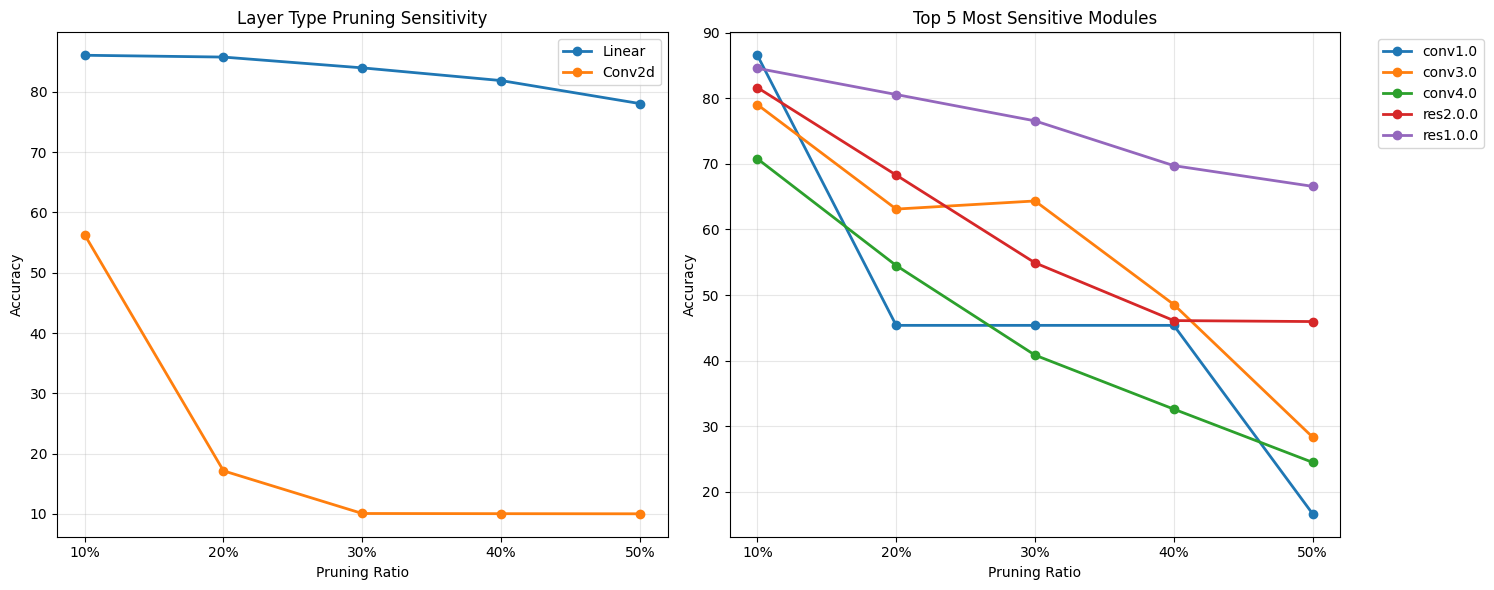


SENSITIVITY ANALYSIS SUMMARY

Layer Type Sensitivity (Accuracy drop from 10% to 50% pruning):
Linear: 802.00% accuracy drop
Conv2d: 4630.00% accuracy drop

Top 5 Most Sensitive Modules:
1. conv1.0: 6996.00% accuracy drop
2. conv3.0: 5073.00% accuracy drop
3. conv4.0: 4632.00% accuracy drop
4. res2.0.0: 3570.00% accuracy drop
5. res1.0.0: 1801.00% accuracy drop


In [ ]:
####
# Using ln_structured pruning, prune different modules
# Then, plot the importances of each module at pruning rates as a line graph with pruning percentage on x axis and accuracy on y axis.
#
# You need to finish this.

def prune_and_eval(model, module, tensor_name, amount):
  """
  Will modify model in place! must pass in clone of it
  """
  tensor_name = "weight"

  if not hasattr(module, tensor_name):
    return 0, 0

  param_tensor = getattr(module, tensor_name)
  if param_tensor.ndim == 4 or param_tensor.ndim == 2:    
    # conv 2d weight or linear weight
    # else this is a 1D tensor and pruning that can cause a headache

    # prune input channels
    # this mathematically is the (almost) the same as pruning output channels from prev layer
    prune.ln_structured(module, tensor_name, amount, n=2, dim=1)
  else:
    return 0, 0

  

  _, acc = evaluate_test(model, test_loader)

  count_delta = getattr(module, f"{tensor_name}_mask").sum().item() - param_tensor.numel()
  param_count = total_params + count_delta

  return acc, param_count

def deepcopy_model(model, name):
  model_copy = copy.deepcopy(model)

  if name == None:
    return model_copy

  for name_copy, module_copy in model_copy.named_modules():
    if name == name_copy:
      return model_copy, module_copy
    
  raise RuntimeError(f"Could not find model copy {name}")

layer_type_results = []
module_results = []

# Layer type experiments
#print("========== LAYER TYPE EXPERIMENTS ==========")
for layer_type in [nn.Linear, nn.Conv2d]:
  for amount in [0.1, 0.2, 0.3, 0.4, 0.5]:
    model_copy = deepcopy_model(model, None)
    
    accum_delta = 0
    accum_count = 0
    for name, module in model_copy.named_modules():
      if isinstance(module, layer_type): 
        acc, params = prune_and_eval(model_copy, module, "weight", amount)

        accum_delta += params
        accum_count += 1
    
    # Calculate compression ratio
    params = accum_delta - total_params * (accum_count - 1)
    compression_ratio = params / total_params
    
    layer_type_results.append({
        'Layer Type': layer_type.__name__,
        'Pruning Ratio': f"{amount:.0%}",
        'Accuracy': f"{acc:.2%}",
        'Pruned Params': params,
        'Compression Ratio': f"{compression_ratio:.2f}x",
        'Amount': amount,
        'Acc_float': acc
    })
    
    #print(f"{layer_type.__name__}\t{amount}\t{acc:.4f}\t{params}")

# Create layer type summary table
layer_df = pd.DataFrame(layer_type_results)
print("\n" + "="*80)
print("LAYER TYPE PRUNING SUMMARY")
print("="*80)
print(layer_df[['Layer Type', 'Pruning Ratio', 'Accuracy', 'Pruned Params', 'Compression Ratio']].to_string(index=False))

# Individual module experiments
#print("\n========== INDIVIDUAL MODULE EXPERIMENTS ==========")
for name, module in model.named_modules():
  if name and list(module.parameters(recurse=False)):
    for amount in [0.1, 0.2, 0.3, 0.4, 0.5]:
      model_copy, module_copy = deepcopy_model(model, name)
      acc, params = prune_and_eval(model_copy, module_copy, "weight", amount)
      
      if params != 0:  # Only include modules where pruning is applicable
        compression_ratio = params / total_params
        
        module_results.append({
            'Module Name': name,
            'Module Type': type(module_copy).__name__,
            'Pruning Ratio': f"{amount:.0%}",
            'Accuracy': f"{acc:.2%}",
            'Pruned Params': params,
            'Compression Ratio': f"{compression_ratio:.2f}x",
            'Amount': amount,
            'Acc_float': acc
        })
        
        #print(f"{type(module_copy).__name__}\t{name}\t{amount}\t{acc:.4f}\t{params}")

# Create module summary table
module_df = pd.DataFrame(module_results)
print("\n" + "="*100)
print("MODULE-LEVEL PRUNING SUMMARY (Top 20 results)")
print("="*100)
print(module_df[['Module Name', 'Module Type', 'Pruning Ratio', 'Accuracy', 'Pruned Params', 'Compression Ratio']].head(20).to_string(index=False))

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Layer Type Results
layer_df_plot = pd.DataFrame(layer_type_results)
for layer_type in layer_df_plot['Layer Type'].unique():
    layer_data = layer_df_plot[layer_df_plot['Layer Type'] == layer_type]
    ax1.plot(layer_data['Amount'], layer_data['Acc_float'], 'o-', label=layer_type, linewidth=2, markersize=6)

ax1.set_xlabel('Pruning Ratio')
ax1.set_ylabel('Accuracy')
ax1.set_title('Layer Type Pruning Sensitivity')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax1.set_xticklabels(['10%', '20%', '30%', '40%', '50%'])

# Plot 2: Individual Module Results (top modules by sensitivity)
module_df_plot = pd.DataFrame(module_results)

# Calculate sensitivity (accuracy drop from 10% to 50% pruning)
module_sensitivity = {}
for module_name in module_df_plot['Module Name'].unique():
  module_data = module_df_plot[module_df_plot['Module Name'] == module_name].sort_values('Amount')
  if len(module_data) >= 2:
    acc_drop = module_data.iloc[0]['Acc_float'] - module_data.iloc[-1]['Acc_float']
    module_sensitivity[module_name] = acc_drop

# Plot top 5 most sensitive modules
top_modules = sorted(module_sensitivity.items(), key=lambda x: x[1], reverse=True)[:5]

for module_name, _ in top_modules:
  module_data = module_df_plot[module_df_plot['Module Name'] == module_name]
  ax2.plot(module_data['Amount'], module_data['Acc_float'], 'o-', label=module_name, linewidth=2, markersize=6)

ax2.set_xlabel('Pruning Ratio')
ax2.set_ylabel('Accuracy')
ax2.set_title('Top 5 Most Sensitive Modules')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax2.set_xticklabels(['10%', '20%', '30%', '40%', '50%'])

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*80)
print("SENSITIVITY ANALYSIS SUMMARY")
print("="*80)
print("\nLayer Type Sensitivity (Accuracy drop from 10% to 50% pruning):")
layer_sensitivity = {}
for layer_type in layer_df_plot['Layer Type'].unique():
  layer_data = layer_df_plot[layer_df_plot['Layer Type'] == layer_type].sort_values('Amount')
  if len(layer_data) >= 2:
    acc_drop = layer_data.iloc[0]['Acc_float'] - layer_data.iloc[-1]['Acc_float']
    layer_sensitivity[layer_type] = acc_drop
    print(f"{layer_type}: {acc_drop:.2%} accuracy drop")

if module_results and top_modules:
  print(f"\nTop 5 Most Sensitive Modules:")
  for i, (module_name, sensitivity) in enumerate(top_modules, 1):
    print(f"{i}. {module_name}: {sensitivity:.2%} accuracy drop")


### Write your results for 1-3 here.


### [10%] Part d: Explaining Pruning

#### [5%] Pruning Sensitivity Analysis and Hypothesis

Based on your module-wise pruning experiments and results, analyze the patterns you observed:

**Note:** You should conduct pruning sensitivity experiments across different **module types** (e.g., attention layers, MLP blocks, residual connections).

Use your findings to support the following analyses:

1. **Module Robustness Hypothesis**:
   - Examine your pruning sensitivity graphs for different **module types**.
   - Identify which modules were most or least robust to pruning.
   - Hypothesize why certain modules tolerate more pruning (e.g., feature complexity, redundancy, gradient flow, or functional role).

2. **Progressive Pruning Trends**:
   - Describe how sensitivity patterns change with increasing pruning ratios.
   - Identify any non-linear trends or abrupt drops in performance.
   - Interpret these effects in terms of capacity, redundancy, or structural importance.

3. **Module-Specific Observations**:
   - Highlight differences in pruning sensitivity across module types.
   - Discuss how components like residual connections influence pruning robustness.
   - Comment on any notable behavior of auxiliary modules such as normalization layers.

**[Answer]:** *(Provide your analysis here based on your experimental results)*
1. Convolution networks were far more susceptible to pruning to that linear layers. Part of that is due to pruning taking out the first convolution layer's input channels, which drastically decreases accuracy. This is because at the initial stage, we have very limited information, so each channel counts. The linear layer's lack of sensitvity is also understandable. We have approximately 512 input channels, and chances are many of them are redundant indicators for a class. We hypothesize the much higher sensitivity of the convolution layer compared to the linear layer is that the convolution network is doing the heavy lifting of *understanding* the image, where as the linear layer is just aggregating that understanding. Also, the convolution layers are typically deeper in the model architecture, and thus errors from pruning are more likely to propagate to newer layers.

2. Convolution layers take a sharp nosedive right off the bat until the stabalize at ~10% accuracy, which is equal to a random guess. The nosedive is likely due to the fact that convolution layers are much more sensitive to pruning than linear layers. The accuracy drop between pruning rations for linear layers increases as the pruning ratio gets higher. This is likely because pruning initially gets rid of useless features, but as time goes on, we start removing more important features. Had we continued pruning, this curve would become even more nonlinear, until it slows down and it hits the 10% random guess floor. This is because we cannot be more inaccurate than 10%. 

3. Of all modules, the first convolution layer was the most sensitive to pruning of input channels, and the linear layer was the least sensitive. For the first convolution layer, the answer is simple: at the initial stage, we have very limited information, so each channel counts. Pruning those input channels (especially without retraining) destroys the flow of information in our model, causing massive accuracy drops.  Conv4 (the last conv layer before the linear layer) was also surprisingly sensitive. We hypothesize that this is because that layer does the heavy lifting of transforming the latent representation of the image into something ready for prediction.

---

#### [5%] Alternative Pruning Metrics

While this exercise used L2 norm for pruning decisions, many other importance metrics exist. List **5 creative pruning metrics** beyond simple L_p norms:

**Reference**: You may explore the [Torch Pruning library](https://github.com/VainF/Torch-Pruning) documentation for inspiration, but provide original explanations.

**Required Format**: For each metric, provide:
- Metric name and brief description
- Intuition for why it might be effective
- Potential advantages/disadvantages

**Example Metrics to Explore:**
- Gradient-based importance measures
- Activation-based metrics
- Information-theoretic approaches
- Network connectivity measures
- Task-specific importance scores

---

#### [2%] Bonus: Pruning vs. Quantization Trade-offs

Both pruning and quantization reduce model size, but through different mechanisms. Analyze when each approach is preferable:

**Required Analysis:**

1. **When Pruning is Better**:
  - Identify scenarios where removing parameters entirely is more beneficial than reducing precision
  - Consider hardware constraints, inference patterns, and model architectures
  - Discuss memory vs. computational trade-offs

2. **When Quantization is Better**:
  - Explain situations where reducing bit precision is more effective than removing parameters
  - Consider deployment constraints and hardware acceleration
  - Discuss preservation of model capacity vs. efficiency gains

3. **Hybrid Approaches**:
  - Describe scenarios where combining both techniques might be optimal
  - Consider the order of application (prune-then-quantize vs. quantize-then-prune)

**Note**: There is no single correct answer. Provide thoughtful analysis based on different use cases, hardware constraints, and performance requirements.

---